# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [6]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [7]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [8]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x, activation=0)  # сигмоїд для першого шару
    x = self.layer_2(x, activation=0)  # сигмоїд для другого шару
    return self.output_layer(x, activation=1)  # softmax для вихідного шару

In [9]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    # Отримуємо індекс класу з максимальною ймовірністю (модель передбачає цей клас)
    predicted_class = tf.argmax(y_pred, axis=1, output_type=tf.int64)

    # Перетворюємо y_true на тип int64
    y_true = tf.cast(y_true, tf.int64)
    
    # Порівнюємо з фактичними класами
    correct_prediction = tf.equal(predicted_class, y_true)

    # Обчислюємо точність як середнє значення правильних передбачень
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [10]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримуємо список оптимізованих параметрів (trainable variables)
    # Це параметри мережі, які будуть оновлюватися: ваги та зміщення
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    # Обчислюємо градієнти втрат відносно параметрів моделі
    gradients = g.gradient(loss, trainable_variables)
    # Модифікуємо параметри
    # Оновлюємо параметри моделі за допомогою оптимізатора
    optimizer.apply_gradients(zip(gradients, trainable_variables))
      
    return loss, gradients

In [11]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    loss, gradients = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Місце для вашого коду
        acc = accuracy(pred, batch_y)

        # Додаємо поточні значення втрат і точності до історії
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

        # Виводимо значення на екран
        print(f"Step {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")


Step 100, Loss: 360.6695861816406, Accuracy: 0.66796875
Step 200, Loss: 216.15646362304688, Accuracy: 0.796875
Step 300, Loss: 215.1077880859375, Accuracy: 0.796875
Step 400, Loss: 139.86740112304688, Accuracy: 0.8359375
Step 500, Loss: 130.155029296875, Accuracy: 0.86328125
Step 600, Loss: 110.55166625976562, Accuracy: 0.875
Step 700, Loss: 143.43621826171875, Accuracy: 0.8515625
Step 800, Loss: 164.85873413085938, Accuracy: 0.84375
Step 900, Loss: 111.37574768066406, Accuracy: 0.86328125
Step 1000, Loss: 124.38726043701172, Accuracy: 0.859375
Step 1100, Loss: 72.69471740722656, Accuracy: 0.90625
Step 1200, Loss: 91.34466552734375, Accuracy: 0.8984375
Step 1300, Loss: 91.29727172851562, Accuracy: 0.91015625
Step 1400, Loss: 64.34043884277344, Accuracy: 0.9453125
Step 1500, Loss: 100.49661254882812, Accuracy: 0.8984375
Step 1600, Loss: 75.41508483886719, Accuracy: 0.9296875
Step 1700, Loss: 109.4613265991211, Accuracy: 0.890625
Step 1800, Loss: 133.482177734375, Accuracy: 0.87109375
St

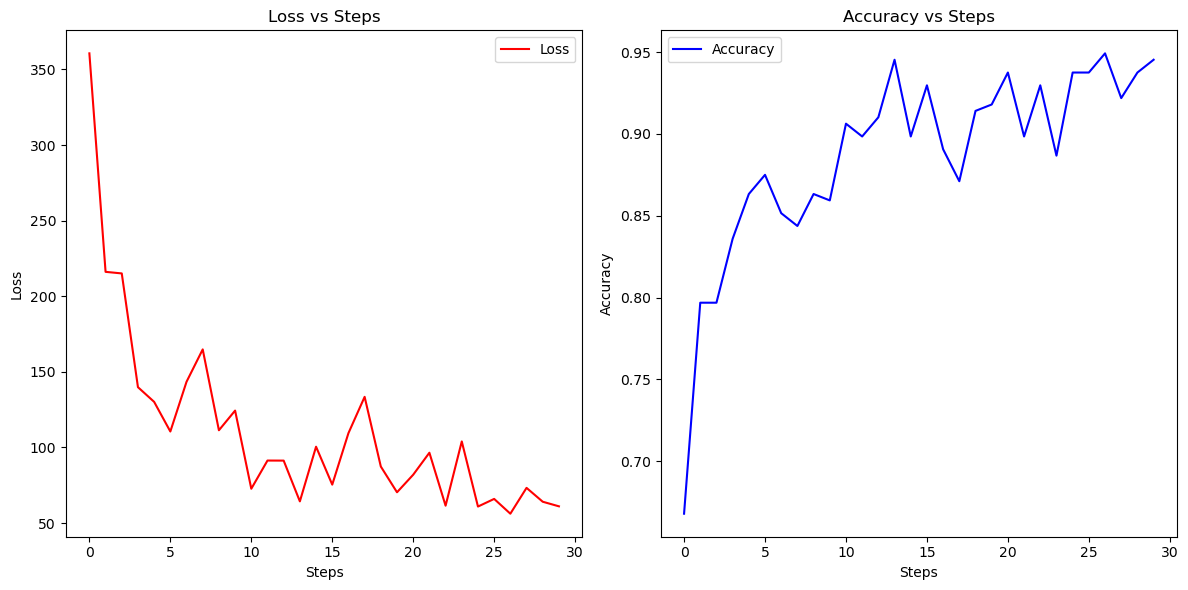

In [12]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))  # Розмір графіка
plt.subplot(1, 2, 1)  # Перша підпанель для втрат
plt.plot(loss_history, label='Loss', color='r')
plt.title('Loss vs Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Виведіть графік точності
plt.subplot(1, 2, 2)  # Друга підпанель для точності
plt.plot(accuracy_history, label='Accuracy', color='b')
plt.title('Accuracy vs Steps')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

# Показуємо графіки
plt.tight_layout()
plt.show()

In [13]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
# Тестування моделі на тестових даних
# Місце для вашого коду

# Оцінка точності на тестовому наборі даних
def evaluate_model(neural_net, x_test, y_test):
    # Отримуємо передбачення моделі на тестовому наборі
    y_pred = neural_net(x_test)

    # Обчислюємо точність на тестовому наборі
    acc = accuracy(y_pred, y_test)
    
    return acc

# Тестування моделі на тестових даних
test_accuracy = evaluate_model(neural_net, x_test, y_test)

# Виводимо результат
print(f"Test Accuracy: {test_accuracy.numpy()}")

Test Accuracy: 0.9039000272750854


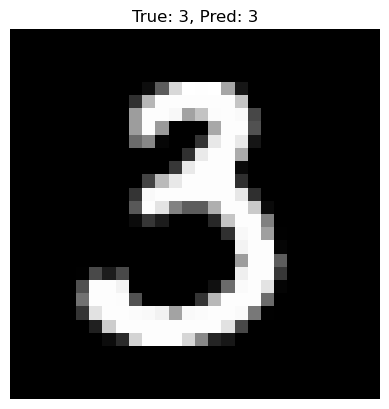

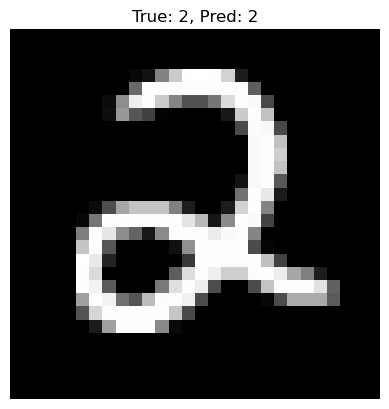

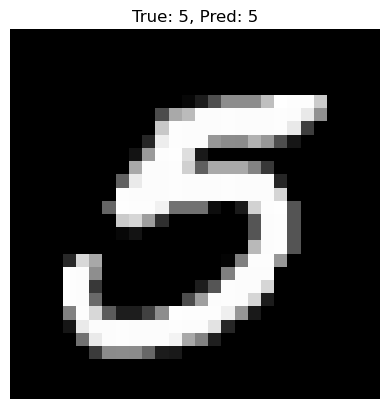

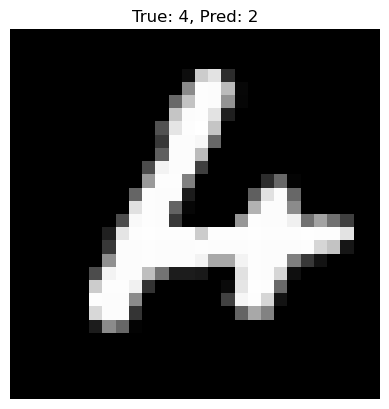

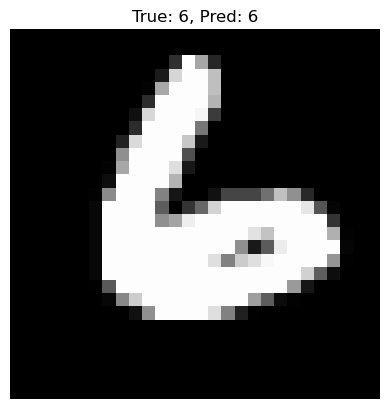

Number of correct predictions: 4
Error rate: 20.00%


In [14]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Вибираємо 5 випадкових зображень із тестового набору
random_indices = random.sample(range(len(x_test)), 5)

# Створюємо списки для зображень, істинних міток та передбачень
images = x_test[random_indices]
true_labels = y_test[random_indices]
predictions = []

# Передаємо зображення через нейронну мережу та отримуємо передбачення
for image in images:
    image = np.expand_dims(image, axis=0)  # Змінюємо розмірність, щоб передати у модель (batch size = 1)
    pred = neural_net(image)  # Отримуємо передбачення
    predicted_label = np.argmax(pred, axis=1)  # Отримуємо клас з найбільшим значенням ймовірності
#    predictions.append(predicted_label.numpy()[0])  # Додаємо прогноз в список
    predictions.append(predicted_label[0])

# Виводимо зображення та відповідні передбачення
for i in range(len(images)):
    plt.imshow(images[i].reshape(28, 28), cmap='gray')  # Перетворюємо вектор зображення назад у 2D
    plt.title(f"True: {true_labels[i]}, Pred: {predictions[i]}")
    plt.axis('off')
    plt.show()

# Аналіз результатів
correct_predictions = sum([true_labels[i] == predictions[i] for i in range(len(images))])
error_rate = 1 - correct_predictions / len(images)

print(f"Number of correct predictions: {correct_predictions}")
print(f"Error rate: {error_rate * 100:.2f}%")



In [17]:
from sklearn import datasets, metrics, svm
print(
    f"Classification report for classifier :\n"
    f"{metrics.classification_report(true_labels, predictions, zero_division=1)}\n"
)

Classification report for classifier :
              precision    recall  f1-score   support

           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         1
           4       1.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1

    accuracy                           0.80         5
   macro avg       0.90      0.80      0.73         5
weighted avg       0.90      0.80      0.73         5




In [ ]:
Висновки:
Модель добре працює для чисел 3, 5, 6, даючи 100% точність і чутливість.
Модель погано працює з 2 і 4. 
При роботі з 4, не було жодного правильного передбачення.
Для класу 2 модель має змішані результати, з хорошим recall, але з низькою точністю.